# Content

__1. Exploratory Visualization__  
__2. Data Cleaning__  
__3. Feature Engineering__  
__4. Modeling & Evaluation__  
__5. Ensemble Methods__  

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
plt.style.use('ggplot')

In [2]:
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline, make_pipeline
from scipy.stats import skew
from sklearn.decomposition import PCA, KernelPCA
from sklearn.impute import SimpleImputer   #  填充空值

In [3]:
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.svm import SVR, LinearSVR
from sklearn.linear_model import ElasticNet, SGDRegressor, BayesianRidge
from sklearn.kernel_ridge import KernelRidge
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

In [4]:
pd.set_option('max_colwidth',200)
pd.set_option('display.width',200)
pd.set_option('display.max_columns',500)
pd.set_option('display.max_rows',1000)

In [5]:
train=pd.read_csv(r'D:\JupyterProject\house-prices-advanced-regression-techniques\train.csv')
test=pd.read_csv(r'D:\JupyterProject\house-prices-advanced-regression-techniques\test.csv')

In [6]:
train.drop(train[(train["GrLivArea"]>4000)&(train["SalePrice"]<300000)].index,inplace=True)    # 删除离群样本

In [7]:
full=pd.concat([train,test], ignore_index=True)     #   合并训练样本和测试样本，保证属性完整

In [8]:
full.drop(['Id'],axis=1, inplace=True)    #   删除Id列
full.shape

(2917, 80)

# Data Cleaning

### Missing Data

In [9]:
#  空值

aa = full.isnull().sum()
aa[aa>0].sort_values(ascending=False)

PoolQC          2908
MiscFeature     2812
Alley           2719
Fence           2346
SalePrice       1459
FireplaceQu     1420
LotFrontage      486
GarageCond       159
GarageYrBlt      159
GarageFinish     159
GarageQual       159
GarageType       157
BsmtExposure      82
BsmtCond          82
BsmtQual          81
BsmtFinType2      80
BsmtFinType1      79
MasVnrType        24
MasVnrArea        23
MSZoning           4
Functional         2
BsmtHalfBath       2
BsmtFullBath       2
Utilities          2
KitchenQual        1
TotalBsmtSF        1
BsmtUnfSF          1
GarageCars         1
GarageArea         1
BsmtFinSF2         1
BsmtFinSF1         1
Exterior2nd        1
Exterior1st        1
SaleType           1
Electrical         1
dtype: int64

+ __Let's first imput the missing values of LotFrontage based on the median of LotArea and Neighborhood. Since LotArea is a continuous feature, We use qcut to divide it into 10 parts.__

In [10]:
full.groupby(['Neighborhood'])[['LotFrontage']].agg(['mean','median','count'])        #  按照Neighborhood分类，返回不同Neighborhood类的LofFrontage特征的平均值(mean)，中位数(median)，个数(count)

LotFrontage             
                    mean median count
Neighborhood                         
Blmngtn        46.900000   43.0    20
Blueste        27.300000   24.0    10
BrDale         21.500000   21.0    30
BrkSide        55.789474   51.0    95
ClearCr        88.150000   80.5    20
CollgCr        71.336364   70.0   220
Crawfor        69.951807   70.0    83
Edwards        65.153409   64.5   176
Gilbert        74.207207   64.0   111
IDOTRR         62.241379   60.0    87
MeadowV        25.606061   21.0    33
Mitchel        75.144444   74.0    90
NAmes          75.210667   73.0   375
NPkVill        28.142857   24.0    21
NWAmes         81.517647   80.0    85
NoRidge        91.629630   89.0    54
NridgHt        84.184049   92.0   163
OldTown        61.777293   60.0   229
SWISU          59.068182   60.0    44
Sawyer         74.551020   72.0    98
SawyerW        70.669811   67.0   106
Somerst        64.549383   72.5   162
StoneBr        62.173913   60.0    46
Timber         81.157895   82.0    57
Veenker        72.000000   80.0    16

In [11]:
full["LotAreaCut"] = pd.qcut(full.LotArea,10)      #新增特征LotAreaCut, 以10分位数将LotArea分箱， 10%，20%………………，默认标签

In [12]:
full.groupby(['LotAreaCut'])[['LotFrontage']].agg(['mean','median','count'])

LotFrontage             
                           mean median count
LotAreaCut                                  
(1299.999, 4921.8]    35.741036   34.0   251
(4921.8, 7007.2]      55.460674   52.0   267
(7007.2, 7949.0]      62.959839   62.0   249
(7949.0, 8740.4]      67.113725   65.0   255
(8740.4, 9452.0]      69.959184   70.0   245
(9452.0, 10148.8]     73.988235   75.0   255
(10148.8, 11000.0]    73.636364   75.0   253
(11000.0, 12196.8]    83.371681   82.0   226
(12196.8, 14285.8]    84.973684   85.0   228
(14285.8, 215245.0]   92.846535   90.0   202

In [13]:
full['LotFrontage']=full.groupby(['LotAreaCut','Neighborhood'])['LotFrontage'].transform(lambda x: x.fillna(x.median())) 

#   按LotAreaCut，Neighborhood分类，并在用分类后的中位数填充空值

In [14]:
# Since some combinations of LotArea and Neighborhood are not available, so we just LotAreaCut alone.
# 由于LotArea和Neighborhood的某些组合是不可用的，所以我们只能单独LotAreaCut。

full['LotFrontage']=full.groupby(['LotAreaCut'])['LotFrontage'].transform(lambda x: x.fillna(x.median()))

+ __Then we filling in other missing values according to data_description.__

In [15]:
# 在这些列空值处填充0，数字特征

cols=["MasVnrArea", "BsmtUnfSF", "TotalBsmtSF", "GarageCars", "BsmtFinSF2", "BsmtFinSF1", "GarageArea"]
for col in cols:
    full[col].fillna(0, inplace=True) 

In [16]:
cols1 = ["PoolQC" , "MiscFeature", "Alley", "Fence", "FireplaceQu", "GarageQual", "GarageCond", "GarageFinish", "GarageYrBlt", "GarageType", "BsmtExposure", "BsmtCond", "BsmtQual", "BsmtFinType2", "BsmtFinType1", "MasVnrType"]
for col in cols1:
    full[col].fillna("None", inplace=True)      #将cols1中的特征所包含的空值填充为"None"，文本特征

In [17]:
# fill in with mode
cols2 = ["MSZoning", "BsmtFullBath", "BsmtHalfBath", "Utilities", "Functional", "Electrical", "KitchenQual", "SaleType","Exterior1st", "Exterior2nd"]
for col in cols2:
    full[col].fillna(full[col].mode()[0], inplace=True)     #将cols2中的特征所包含的空值填充为该列的众数 

+ __And there is no missing data except for the value we want to predict !__

In [18]:
full.isnull().sum()[full.isnull().sum()>0]        #检查空值，空值为test的SalePrice,因此空值已完全填充

SalePrice    1459
dtype: int64

# Feature Engineering

+ __Convert some numerical features into categorical features. It's better to use LabelEncoder and get_dummies for these features.__

In [19]:
# 将一些数字特征转换为分裂特征以便进行数字标签编码和one_hot编码

NumStr = ["MSSubClass","BsmtFullBath","BsmtHalfBath","HalfBath","BedroomAbvGr","KitchenAbvGr","MoSold","YrSold","YearBuilt","YearRemodAdd","LowQualFinSF","GarageYrBlt"]
for col in NumStr:
    full[col]=full[col].astype(str)

In [20]:
full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2917 entries, 0 to 2916
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   MSSubClass     2917 non-null   object  
 1   MSZoning       2917 non-null   object  
 2   LotFrontage    2917 non-null   float64 
 3   LotArea        2917 non-null   int64   
 4   Street         2917 non-null   object  
 5   Alley          2917 non-null   object  
 6   LotShape       2917 non-null   object  
 7   LandContour    2917 non-null   object  
 8   Utilities      2917 non-null   object  
 9   LotConfig      2917 non-null   object  
 10  LandSlope      2917 non-null   object  
 11  Neighborhood   2917 non-null   object  
 12  Condition1     2917 non-null   object  
 13  Condition2     2917 non-null   object  
 14  BldgType       2917 non-null   object  
 15  HouseStyle     2917 non-null   object  
 16  OverallQual    2917 non-null   int64   
 17  OverallCond    2917 non-null   in

+ __Now I want to do a long list of value-mapping. __
+ __I was influenced by the insight that we should build as many features as possible and trust the model to choose the right features. So I decided to groupby SalePrice according to one feature and sort it based on mean and median. Here is an example:__

In [21]:
full.groupby(['MSSubClass'])[['SalePrice']].agg(['mean','median','count'])    #    单个特征和SalePrice的关系，并依此按顺序进行数字标签编码

SalePrice                
                     mean    median count
MSSubClass                               
120         200779.080460  192000.0    87
150                   NaN       NaN     0
160         138647.380952  146000.0    63
180         102300.000000   88500.0    10
190         129613.333333  128250.0    30
20          185224.811567  159250.0   536
30           95829.724638   99900.0    69
40          156125.000000  142500.0     4
45          108591.666667  107500.0    12
50          143302.972222  132000.0   144
60          240403.542088  216000.0   297
70          166772.416667  156000.0    60
75          192437.500000  163500.0    16
80          169736.551724  166500.0    58
85          147810.000000  140750.0    20
90          133541.076923  135980.0    52

+ __So basically I'll do__  
                '180' : 1
                '30' : 2   '45' : 2
                '190' : 3, '50' : 3, '90' : 3,
                '85' : 4, '40' : 4, '160' : 4
                '70' : 5, '20' : 5, '75' : 5, '80' : 5, '150' : 5
                '120': 6, '60' : 6

+ __Different people may have different views on how to map these values, so just follow your instinct =^_^=__  
__Below I also add a small "o" in front of the features so as to keep the original features to use get_dummies in a moment.__

In [22]:
def map_values():                          #  给分类标签进行数字编码
    full["oMSSubClass"] = full.MSSubClass.map({'180':1, 
                                        '30':2, '45':2, 
                                        '190':3, '50':3, '90':3, 
                                        '85':4, '40':4, '160':4, 
                                        '70':5, '20':5, '75':5, '80':5, '150':5,
                                        '120': 6, '60':6})
    
    full["oMSZoning"] = full.MSZoning.map({'C (all)':1, 'RH':2, 'RM':2, 'RL':3, 'FV':4})
    
    full["oNeighborhood"] = full.Neighborhood.map({'MeadowV':1,
                                               'IDOTRR':2, 'BrDale':2,
                                               'OldTown':3, 'Edwards':3, 'BrkSide':3,
                                               'Sawyer':4, 'Blueste':4, 'SWISU':4, 'NAmes':4,
                                               'NPkVill':5, 'Mitchel':5,
                                               'SawyerW':6, 'Gilbert':6, 'NWAmes':6,
                                               'Blmngtn':7, 'CollgCr':7, 'ClearCr':7, 'Crawfor':7,
                                               'Veenker':8, 'Somerst':8, 'Timber':8,
                                               'StoneBr':9,
                                               'NoRidge':10, 'NridgHt':10})
    
    full["oCondition1"] = full.Condition1.map({'Artery':1,
                                           'Feedr':2, 'RRAe':2,
                                           'Norm':3, 'RRAn':3,
                                           'PosN':4, 'RRNe':4,
                                           'PosA':5 ,'RRNn':5})
    
    full["oBldgType"] = full.BldgType.map({'2fmCon':1, 'Duplex':1, 'Twnhs':1, '1Fam':2, 'TwnhsE':2})
    
    full["oHouseStyle"] = full.HouseStyle.map({'1.5Unf':1, 
                                           '1.5Fin':2, '2.5Unf':2, 'SFoyer':2, 
                                           '1Story':3, 'SLvl':3,
                                           '2Story':4, '2.5Fin':4})
    
    full["oExterior1st"] = full.Exterior1st.map({'BrkComm':1,
                                             'AsphShn':2, 'CBlock':2, 'AsbShng':2,
                                             'WdShing':3, 'Wd Sdng':3, 'MetalSd':3, 'Stucco':3, 'HdBoard':3,
                                             'BrkFace':4, 'Plywood':4,
                                             'VinylSd':5,
                                             'CemntBd':6,
                                             'Stone':7, 'ImStucc':7})
    
    full["oMasVnrType"] = full.MasVnrType.map({'BrkCmn':1, 'None':1, 'BrkFace':2, 'Stone':3})
    
    full["oExterQual"] = full.ExterQual.map({'Fa':1, 'TA':2, 'Gd':3, 'Ex':4})
    
    full["oFoundation"] = full.Foundation.map({'Slab':1, 
                                           'BrkTil':2, 'CBlock':2, 'Stone':2,
                                           'Wood':3, 'PConc':4})
    
    full["oBsmtQual"] = full.BsmtQual.map({'Fa':2, 'None':1, 'TA':3, 'Gd':4, 'Ex':5})
    
    full["oBsmtExposure"] = full.BsmtExposure.map({'None':1, 'No':2, 'Av':3, 'Mn':3, 'Gd':4})
    
    full["oHeating"] = full.Heating.map({'Floor':1, 'Grav':1, 'Wall':2, 'OthW':3, 'GasW':4, 'GasA':5})
    
    full["oHeatingQC"] = full.HeatingQC.map({'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5})
    
    full["oKitchenQual"] = full.KitchenQual.map({'Fa':1, 'TA':2, 'Gd':3, 'Ex':4})
    
    full["oFunctional"] = full.Functional.map({'Maj2':1, 'Maj1':2, 'Min1':2, 'Min2':2, 'Mod':2, 'Sev':2, 'Typ':3})
    
    full["oFireplaceQu"] = full.FireplaceQu.map({'None':1, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5})
    
    full["oGarageType"] = full.GarageType.map({'CarPort':1, 'None':1,
                                           'Detchd':2,
                                           '2Types':3, 'Basment':3,
                                           'Attchd':4, 'BuiltIn':5})
    
    full["oGarageFinish"] = full.GarageFinish.map({'None':1, 'Unf':2, 'RFn':3, 'Fin':4})
    
    full["oPavedDrive"] = full.PavedDrive.map({'N':1, 'P':2, 'Y':3})
    
    full["oSaleType"] = full.SaleType.map({'COD':1, 'ConLD':1, 'ConLI':1, 'ConLw':1, 'Oth':1, 'WD':1,
                                       'CWD':2, 'Con':3, 'New':3})
    
    full["oSaleCondition"] = full.SaleCondition.map({'AdjLand':1, 'Abnorml':2, 'Alloca':2, 'Family':2, 'Normal':3, 'Partial':4})            
                
                        
                        
    
    return "Done!"

In [23]:
map_values()

'Done!'

In [24]:
# drop two unwanted columns  去掉不需要的列LotAreaCut,SalePrice        
full.drop("LotAreaCut",axis=1,inplace=True)      #   之前新增的特征现在不要了？
full.drop('SalePrice',axis=1,inplace=True)

## Pipeline

+ __Next we can build a pipeline. It's convenient to experiment different feature combinations once you've got a pipeline.__

+ __Label Encoding three "Year" features.__

In [25]:
class labelenc(BaseEstimator, TransformerMixin):        #  给YearBuilt，YearRemodAdd,GarageYrBlt等特征进行数字编码
    def __init__(self):
        pass
    
    def fit(self,X,y=None):            #   fit  Do Nothing
        return self
    
    def transform(self,X):
        lab=LabelEncoder()
        X["YearBuilt"] = lab.fit_transform(X["YearBuilt"])
        X["YearRemodAdd"] = lab.fit_transform(X["YearRemodAdd"])
        X["GarageYrBlt"] = lab.fit_transform(X["GarageYrBlt"])          
        return X

+ __Apply log1p to the skewed features, then get_dummies.__

In [26]:
class skew_dummies(BaseEstimator, TransformerMixin):                #   One_hot编码转换
    def __init__(self,skew=0.5):
        self.skew = skew
    
    def fit(self,X,y=None):
        return self
    
    def transform(self,X):
        X_numeric=X.select_dtypes(exclude=["object"])
        skewness = X_numeric.apply(lambda x: skew(x))
        skewness_features = skewness[abs(skewness) >= self.skew].index
        X[skewness_features] = np.log1p(X[skewness_features])         
        X = pd.get_dummies(X)
        return X

In [27]:
# build pipeline
pipe = Pipeline([
    ('labenc', labelenc()),
    ('skew_dummies', skew_dummies(skew=1)),
    ])

#

In [28]:
# save the original data for later use
# 保存原始数据，
full2 = full.copy()

In [29]:
data_pipe = pipe.fit_transform(full2)          # pipe：step1  数字标签编码，step2 One-hot编码

In [30]:
data_pipe.shape         #    类函数return X ，返回转换后的训练样本

(2917, 405)

+ __use robustscaler since maybe there are other outliers.__

In [31]:
scaler = RobustScaler()     # 鲁棒性标准器

In [32]:
n_train=train.shape[0]        #训练集样本数

X = data_pipe[:n_train]      # data_pipe是处理过的全部数据，X为训练集
test_X = data_pipe[n_train:] #  测试集
y= train.SalePrice           #   训练集的SalePrice特征为y

X_scaled = scaler.fit(X).transform(X)    #   将训练集X进行鲁棒性转化


y_log = np.log(train.SalePrice)   

#  scipy中的stats.probplot是一种观察数据概率分布的方法，横坐标为分位数，和正态分布对比
#  不符合正态分布时，进行对数转化是一个办法

test_X_scaled = scaler.transform(test_X)    # 测试集鲁棒性转化

## Feature Selection

+ __I have to confess, the feature engineering above is not enough, so we need more.__   
+ __Combining different features is usually a good way, but we have no idea what features should we choose. Luckily there are some models that can provide feature selection, here I use Lasso, but you are free to choose Ridge, RandomForest or GradientBoostingTree.__

In [33]:
lasso=Lasso(alpha=0.001)
lasso.fit(X_scaled,y_log)

Lasso(alpha=0.001)

In [34]:
FI_lasso = pd.DataFrame({"Feature Importance":lasso.coef_}, index=data_pipe.columns)     #    lasso变换得到参数数据

In [35]:
FI_lasso.sort_values("Feature Importance",ascending=False)

,Feature Importance
GrLivArea,1.088601e-01
OverallQual,1.025196e-01
2ndFlrSF,7.424276e-02
YearBuilt,6.883425e-02
1stFlrSF,5.981159e-02
Functional_Typ,5.187783e-02
TotalBsmtSF,5.027809e-02
Neighborhood_Crawfor,4.991413e-02
OverallCond,4.552613e-02
oNeighborhood,4.432890e-02


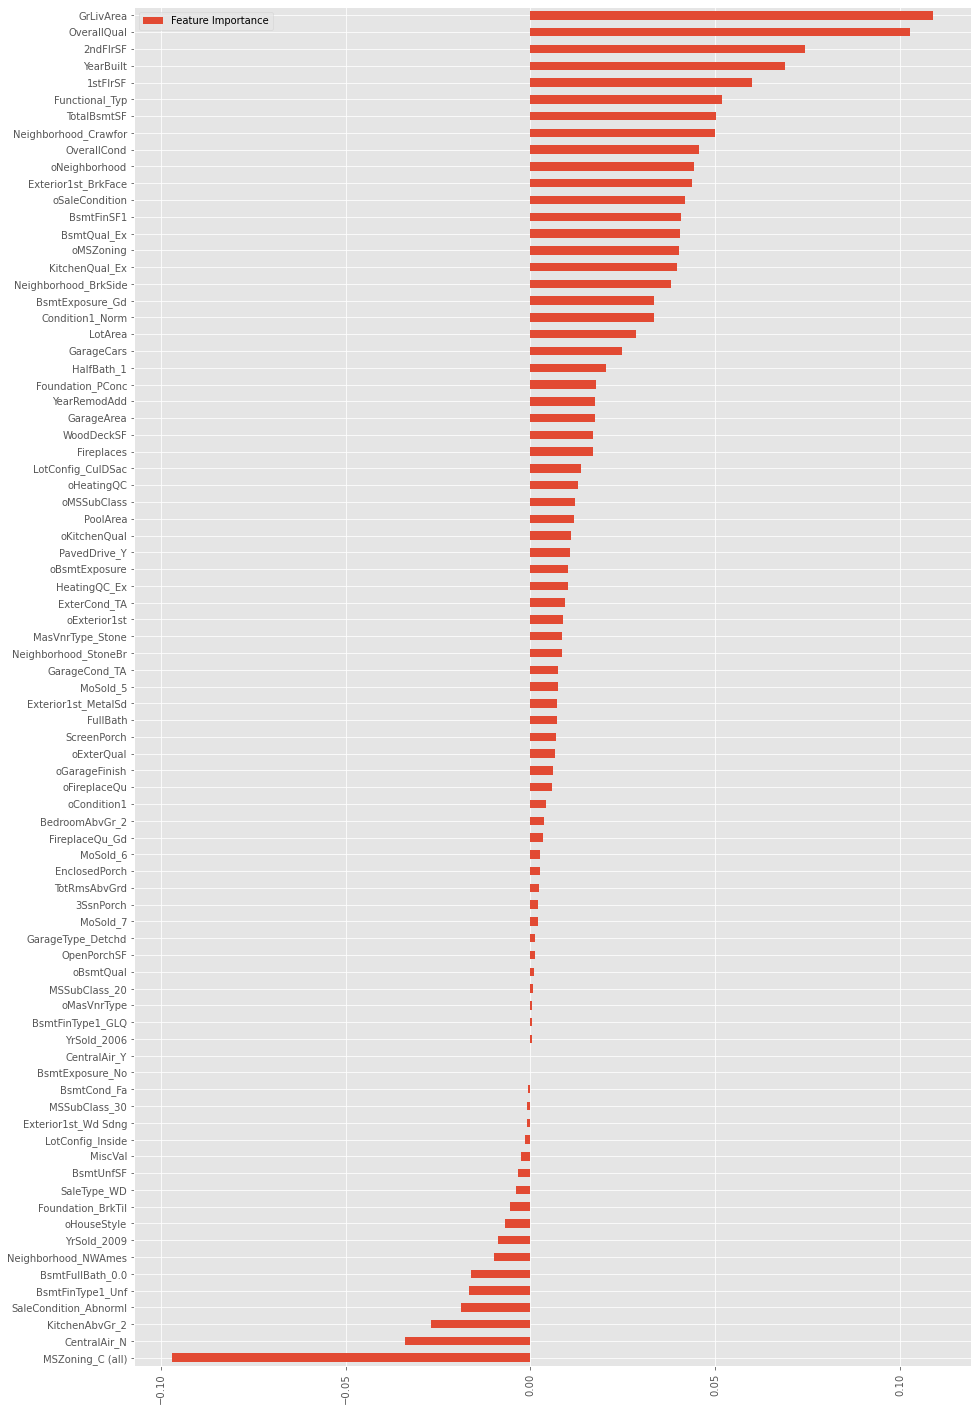

In [36]:
FI_lasso[FI_lasso["Feature Importance"]!=0].sort_values("Feature Importance").plot(kind="barh",figsize=(15,25))
plt.xticks(rotation=90)
plt.show()

+ __Based on the "Feature Importance" plot and other try-and-error, I decided to add some features to the pipeline.__

In [37]:
class add_feature(BaseEstimator, TransformerMixin):
    def __init__(self,additional=1):
        self.additional = additional
    
    def fit(self,X,y=None):
        return self
    
    def transform(self,X):
        if self.additional==1:
            X["TotalHouse"] = X["TotalBsmtSF"] + X["1stFlrSF"] + X["2ndFlrSF"]   
            X["TotalArea"] = X["TotalBsmtSF"] + X["1stFlrSF"] + X["2ndFlrSF"] + X["GarageArea"]
            
        else:
            X["TotalHouse"] = X["TotalBsmtSF"] + X["1stFlrSF"] + X["2ndFlrSF"]   
            X["TotalArea"] = X["TotalBsmtSF"] + X["1stFlrSF"] + X["2ndFlrSF"] + X["GarageArea"]
            
            X["+_TotalHouse_OverallQual"] = X["TotalHouse"] * X["OverallQual"]
            X["+_GrLivArea_OverallQual"] = X["GrLivArea"] * X["OverallQual"]
            X["+_oMSZoning_TotalHouse"] = X["oMSZoning"] * X["TotalHouse"]
            X["+_oMSZoning_OverallQual"] = X["oMSZoning"] + X["OverallQual"]
            X["+_oMSZoning_YearBuilt"] = X["oMSZoning"] + X["YearBuilt"]
            X["+_oNeighborhood_TotalHouse"] = X["oNeighborhood"] * X["TotalHouse"]
            X["+_oNeighborhood_OverallQual"] = X["oNeighborhood"] + X["OverallQual"]
            X["+_oNeighborhood_YearBuilt"] = X["oNeighborhood"] + X["YearBuilt"]
            X["+_BsmtFinSF1_OverallQual"] = X["BsmtFinSF1"] * X["OverallQual"]
            
            X["-_oFunctional_TotalHouse"] = X["oFunctional"] * X["TotalHouse"]
            X["-_oFunctional_OverallQual"] = X["oFunctional"] + X["OverallQual"]
            X["-_LotArea_OverallQual"] = X["LotArea"] * X["OverallQual"]
            X["-_TotalHouse_LotArea"] = X["TotalHouse"] + X["LotArea"]
            X["-_oCondition1_TotalHouse"] = X["oCondition1"] * X["TotalHouse"]
            X["-_oCondition1_OverallQual"] = X["oCondition1"] + X["OverallQual"]
            
           
            X["Bsmt"] = X["BsmtFinSF1"] + X["BsmtFinSF2"] + X["BsmtUnfSF"]
            X["Rooms"] = X["FullBath"]+X["TotRmsAbvGrd"]
            X["PorchArea"] = X["OpenPorchSF"]+X["EnclosedPorch"]+X["3SsnPorch"]+X["ScreenPorch"]
            X["TotalPlace"] = X["TotalBsmtSF"] + X["1stFlrSF"] + X["2ndFlrSF"] + X["GarageArea"] + X["OpenPorchSF"]+X["EnclosedPorch"]+X["3SsnPorch"]+X["ScreenPorch"]

    
            return X

+ __By using a pipeline, you can quickily experiment different feature combinations.__

In [38]:
pipe = Pipeline([
    ('labenc', labelenc()),
    ('add_feature', add_feature(additional=2)),
    ('skew_dummies', skew_dummies(skew=1)),
    ])

## PCA

+ __Im my case, doing PCA is very important. It lets me gain a relatively big boost on leaderboard. At first I don't believe PCA can help me, but 
in retrospect, maybe the reason is that the features I built are highly correlated, and it leads to multicollinearity. PCA can decorrelate these features.__

+ __So I'll use approximately the same dimension in PCA as  in the original data. Since the aim here is not deminsion reduction.__

In [39]:
full_pipe = pipe.fit_transform(full)

In [40]:
full_pipe.shape

(2917, 426)

In [41]:
n_train=train.shape[0]
X = full_pipe[:n_train]
test_X = full_pipe[n_train:]
y= train.SalePrice

X_scaled = scaler.fit(X).transform(X)
y_log = np.log(train.SalePrice)
test_X_scaled = scaler.transform(test_X)

In [42]:
# mycode
class modelSelector:

    """
    score= 'neg_mean_squared_error'
           'accuracy'
    """
    kf = KFold(n_splits=5, shuffle=True)

    def __init__(self, model_dict, score):
        self.model_dict = model_dict
        self.score = score

    def single_model(self,model_name,X,y):

        gridsearch = GridSearchCV(self.model_dict[model_name][0],
                                  self.model_dict[model_name][1],
                                  scoring=self.score,
                                  n_jobs=-1,
                                  cv=self.kf)
        gridsearch.fit(X, y)
        print(model_name, gridsearch.best_params_, gridsearch.best_score_)

    def model_cross_score(self, X, y):

        for i in model_dict:
            gridsearch = GridSearchCV(self.model_dict[i][0],
                                      self.model_dict[i][1],
                                      scoring=self.score,
                                      n_jobs=-1,
                                      cv=self.kf)
            gridsearch.fit(X, y)
            print(i, gridsearch.best_params_, gridsearch.best_score_)
            
            
model_dict = {
              'RG': [Ridge(), {}],
              'ls': [Lasso(),{'alpha': [0.1, 0.01, 0.001]}],
              'RFG': [RandomForestRegressor(),{'n_estimators': [20, 50, 100],
                                               'max_features': ['sqrt', 0.9, 'auto']}],
              'GDBT': [GradientBoostingRegressor(),{}],
              'svr': [SVR(), {'kernel': ['lbf', 'rbf'],
                              'C': [0.1, 0.3, 1],
                              'gamma': ['scale', 'auto']}],
              'BR': [BayesianRidge(),{}],
              'ELN':[ElasticNet(),{}],
              'XG': [XGBRegressor(),{}],
              'lgbm':[LGBMRegressor(),{}]
}

In [45]:

X_p = PCA(n_components=410).fit_transform(X) 
X_scaled.shape

(1458, 426)

In [49]:
modelselect1 = modelSelector(model_dict,'neg_mean_squared_error')
modelselect1.single_model('XG',X_p,y_log)

[22:31:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XG {} -0.021883927554711705


In [51]:
modelselect1 = modelSelector(model_dict,'neg_mean_squared_error')
modelselect1.single_model('ls',X_p,y_log)

ls {'alpha': 0.001} -0.012559178902414592


In [50]:
class stacking(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self,mod,meta_model):
        self.mod = mod
        self.meta_model = meta_model
        self.kf = KFold(n_splits=5, random_state=42, shuffle=True)
        
    def fit(self,X,y):
        self.saved_model = [list() for i in self.mod]
        oof_train = np.zeros((X.shape[0], len(self.mod)))
        
        for i,model in enumerate(self.mod):
            for train_index, val_index in self.kf.split(X,y):
                renew_model = clone(model)
                renew_model.fit(X[train_index], y[train_index])
                self.saved_model[i].append(renew_model)
                oof_train[val_index,i] = renew_model.predict(X[val_index])
        
        self.meta_model.fit(oof_train,y)
        return self
    
    def predict(self,X):
        whole_test = np.column_stack([np.column_stack(model.predict(X) for model in single_model).mean(axis=1) 
                                      for single_model in self.saved_model]) 
        return self.meta_model.predict(whole_test)
    
    def get_oof(self,X,y,test_X):
        oof = np.zeros((X.shape[0],len(self.mod)))
        test_single = np.zeros((test_X.shape[0],5))
        test_mean = np.zeros((test_X.shape[0],len(self.mod)))
        for i,model in enumerate(self.mod):
            for j, (train_index,val_index) in enumerate(self.kf.split(X,y)):
                clone_model = clone(model)
                clone_model.fit(X[train_index],y[train_index])
                oof[val_index,i] = clone_model.predict(X[val_index])
                test_single[:,j] = clone_model.predict(test_X)
            test_mean[:,i] = test_single.mean(axis=1)
        return oof, test_mean

In [51]:
lasso = Lasso(alpha=0.0005,max_iter=10000)
ridge = Ridge(alpha=60)
svr = SVR(gamma= 0.0004,kernel='rbf',C=13,epsilon=0.009)
ker = KernelRidge(alpha=0.2 ,kernel='polynomial',degree=3 , coef0=0.8)
ela = ElasticNet(alpha=0.005,l1_ratio=0.08,max_iter=10000)
bay = BayesianRidge()

In [42]:
a = SimpleImputer().fit_transform(X_scaled)
b = SimpleImputer().fit_transform(y_log.values.reshape(-1,1)).ravel()

In [44]:
stack_model = stacking(mod=[lasso,ridge,svr,ker,ela,bay],meta_model=ker)

In [45]:
stack_model.fit(a,b)

stacking(meta_model=KernelRidge(alpha=0.2, coef0=0.8, kernel='polynomial'),
         mod=[Lasso(alpha=0.0005, max_iter=10000), Ridge(alpha=60),
              SVR(C=13, epsilon=0.009, gamma=0.0004),
              KernelRidge(alpha=0.2, coef0=0.8, kernel='polynomial'),
              ElasticNet(alpha=0.005, l1_ratio=0.08, max_iter=10000),
              BayesianRidge()])

In [55]:
svr.fit(X_p,y_log)
X_pt = PCA(n_components=410).fit_transform(test_X_scaled)

In [56]:
yyy = np.exp(svr.predict(X_pt))
ss = pd.read_csv(r'D:\JupyterProject\house-prices-advanced-regression-techniques\sample_submission.csv')
ss['SalePrice'] = yyy

ss.to_csv("svr.csv", index=False)

In [43]:
#参数搜索空间
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from hyperopt.pyll.base import scope
svm_search_space = {
    'C': hp.uniform('C', 0, 20),
    'kernel': hp.choice('kernel', ['linear', 'sigmoid', 'poly', 'rbf']),
    'gamma': hp.uniform('gamma', 0, 20),
}
lgbm = {}

model_space  = hp.choice('classifier_type', [
    {
        'type': 'naive_bayes',
        'alpha': hp.uniform('alpha', 0.0, 2.0)
    },
    {
        'type': 'svm',
        'C': hp.uniform('C', 0, 10.0),
        'kernel': hp.choice('kernel', ['linear', 'rbf']),
        'gamma': hp.uniform('gamma', 0, 20.0)
    },
    {
        'type': 'randomforest',
        'max_depth': hp.choice('max_depth', range(1,20)),
        'max_features': hp.choice('max_features', range(1,5)),
        'n_estimators': hp.choice('n_estimators', range(1,20)),
        'criterion': hp.choice('criterion', ["gini", "entropy"]),
        'scale': hp.choice('scale', [0, 1]),
        'normalize': hp.choice('normalize', [0, 1])
    },
    {
        'type': 'knn',
        'n_neighbors': hp.choice('knn_n_neighbors', range(1,50))
    }
])

In [ ]:

trials = Trials()

def hyper_search(params):
    svr = SVR(**params)
    kf = KFold(n_splits=4)
    score = cross_val_score(svr, X_p, y_log, 
                            scoring='neg_mean_squared_error', cv=kf,n_jobs=-1).mean()
    return {'loss':-score, 'status': STATUS_OK}




best = fmin(fn=hyper_search, space=svm_search_space,algo=tpe.suggest,max_evals=100, trials=trials)  # 最小化损失，最有参数使fn最小
print(best)
for trial in trials.trials[:2]:
    print(trial)

  3%|█▍                                             | 3/100 [00:03<01:45,  1.09s/trial, best loss: 0.15982308852605678]

In [58]:
 kf = KFold(n_splits=4)
svr = SVR()

cross_val_score(lasso, X_p, y_log, 
                            scoring='neg_mean_squared_error', cv=kf,n_jobs=-1)

array([-0.01089143, -0.01544195, -0.01140245, -0.01111836])

SVR(C=13, epsilon=0.009, gamma=0.0004)